In [1]:
### 未実施の場合
!pip install lightgbm

In [2]:
### 未実施の場合
!pip install kaggle
!pip install --upgrade --force-reinstall --no-deps kaggle


     |████████████████████████████████| 59 kB 6.9 MB/s  eta 0:00:01
  Created wheel for kaggle: filename=kaggle-1.5.10-py3-none-any.whl size=73268 sha256=6273e90039b698e8027b5f4e6c6fd80a3c8faf2845f47a663654f83ca169d119
  Stored in directory: /home/jupyter/.cache/pip/wheels/ea/c5/fe/7e7fb5b3d1f150fac96188949b3d83d375a4c9df16ba557e52
Successfully built kaggle
  Using cached kaggle-1.5.10-py3-none-any.whl
  Attempting uninstall: kaggle
    Found existing installation: kaggle 1.5.10
    Uninstalling kaggle-1.5.10:
      Successfully uninstalled kaggle-1.5.10


In [3]:
### 未実施の場合
!mkdir .kaggle
!mv kaggle.json .kaggle

In [4]:
### 未実施の場合
!kaggle competitions download -c m5-forecasting-accuracy

 72%|███████████████████████████▍          | 33.0M/45.8M [00:01<00:00, 20.7MB/s]
100%|██████████████████████████████████████| 45.8M/45.8M [00:02<00:00, 23.5MB/s]


In [5]:
!ls

'Untitled Folder'   Untitled.ipynb   m5-forecasting-accuracy.zip   tutorials


In [6]:
### 未実施の場合
!mkdir input
!mkdir output
!mv m5-forecasting-accuracy.zip input/
%cd input
!unzip m5-forecasting-accuracy.zip
%cd ../

/home/jupyter/input
Archive:  m5-forecasting-accuracy.zip
  inflating: calendar.csv            
  inflating: sales_train_evaluation.csv  
  inflating: sales_train_validation.csv  
  inflating: sample_submission.csv   
  inflating: sell_prices.csv         
/home/jupyter


In [2]:
import os
import pandas as pd
import numpy as np
import plotly_express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import matplotlib.pyplot as plt
import seaborn as sns
import gc
import warnings
warnings.filterwarnings('ignore')
from lightgbm import LGBMRegressor
import joblib

In [3]:
sales = pd.read_csv('./input/sales_train_evaluation.csv')
sales.name = 'sales'
calendar = pd.read_csv('./input/calendar.csv')
calendar.name = 'calendar'
prices = pd.read_csv('./input/sell_prices.csv')
prices.name = 'prices'

In [4]:
### はじめに、1~1913が配布された
### つぎに、1914~1941のデータが配布された
### 最後に、1942から1969までを予想する。まずは０を格納する。
for d in range(1942,1970):
    col = 'd_' + str(d)
    sales[col] = 0
    sales[col] = sales[col].astype(np.int16)

In [5]:
sales_bd = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_bd = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_bd = np.round(prices.memory_usage().sum()/(1024*1024),1)

In [6]:
#Downcast in order to save memory
def downcast(df):
    cols = df.dtypes.index.tolist()
    types = df.dtypes.values.tolist()
    for i,t in enumerate(types):
        if 'int' in str(t):
            if df[cols[i]].min() > np.iinfo(np.int8).min and df[cols[i]].max() < np.iinfo(np.int8).max:
                df[cols[i]] = df[cols[i]].astype(np.int8)
            elif df[cols[i]].min() > np.iinfo(np.int16).min and df[cols[i]].max() < np.iinfo(np.int16).max:
                df[cols[i]] = df[cols[i]].astype(np.int16)
            elif df[cols[i]].min() > np.iinfo(np.int32).min and df[cols[i]].max() < np.iinfo(np.int32).max:
                df[cols[i]] = df[cols[i]].astype(np.int32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.int64)
        elif 'float' in str(t):
            if df[cols[i]].min() > np.finfo(np.float16).min and df[cols[i]].max() < np.finfo(np.float16).max:
                df[cols[i]] = df[cols[i]].astype(np.float16)
            elif df[cols[i]].min() > np.finfo(np.float32).min and df[cols[i]].max() < np.finfo(np.float32).max:
                df[cols[i]] = df[cols[i]].astype(np.float32)
            else:
                df[cols[i]] = df[cols[i]].astype(np.float64)
        elif t == np.object:
            if cols[i] == 'date':
                df[cols[i]] = pd.to_datetime(df[cols[i]], format='%Y-%m-%d')
            else:
                df[cols[i]] = df[cols[i]].astype('category')
    return df  

sales = downcast(sales)
prices = downcast(prices)
calendar = downcast(calendar)

In [7]:
sales_ad = np.round(sales.memory_usage().sum()/(1024*1024),1)
calendar_ad = np.round(calendar.memory_usage().sum()/(1024*1024),1)
prices_ad = np.round(prices.memory_usage().sum()/(1024*1024),1)

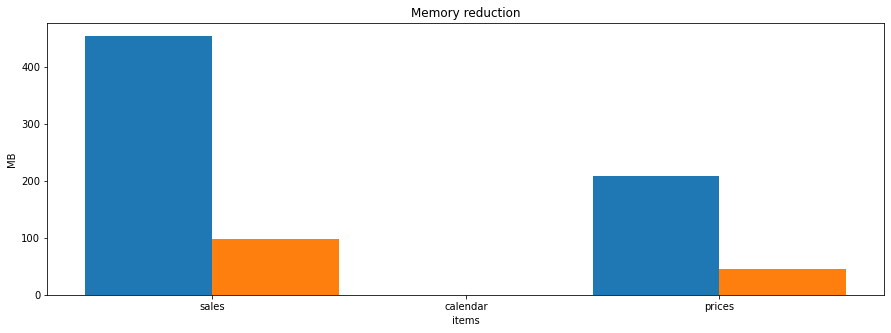

In [42]:
f, ax = plt.subplots(figsize=(15,5))


labels = ["sales", "calendar", "prices"]
height1 = height2 = [sales_bd, calendar_bd, prices_bd]
height2 = [sales_ad, calendar_ad, prices_ad]
x = np.arange(len(height1))
width=0.5
ax.bar(x = x, width=width,height = height1)
ax.bar(x=x+width,width=width,height=height2)
ax.set_xlabel("items")
ax.set_xticks(x+width/2)
ax.set_xticklabels(labels)
ax.set_title("Memory reduction")
ax.set_ylabel("MB")
f.show()

In [47]:
### 元のデータの形
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1960,d_1961,d_1962,d_1963,d_1964,d_1965,d_1966,d_1967,d_1968,d_1969
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [46]:
### データを日付方向に縦列にする

df = pd.melt(sales, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sold').dropna()


                              id        item_id    dept_id   cat_id store_id  \
0  HOBBIES_1_001_CA_1_evaluation  HOBBIES_1_001  HOBBIES_1  HOBBIES     CA_1   
1  HOBBIES_1_002_CA_1_evaluation  HOBBIES_1_002  HOBBIES_1  HOBBIES     CA_1   
2  HOBBIES_1_003_CA_1_evaluation  HOBBIES_1_003  HOBBIES_1  HOBBIES     CA_1   
3  HOBBIES_1_004_CA_1_evaluation  HOBBIES_1_004  HOBBIES_1  HOBBIES     CA_1   
4  HOBBIES_1_005_CA_1_evaluation  HOBBIES_1_005  HOBBIES_1  HOBBIES     CA_1   

  state_id  d_1  d_2  d_3  d_4  ...  d_1960  d_1961  d_1962  d_1963  d_1964  \
0       CA    0    0    0    0  ...       0       0       0       0       0   
1       CA    0    0    0    0  ...       0       0       0       0       0   
2       CA    0    0    0    0  ...       0       0       0       0       0   
3       CA    0    0    0    0  ...       0       0       0       0       0   
4       CA    0    0    0    0  ...       0       0       0       0       0   

   d_1965  d_1966  d_1967  d_1968  d_1969  


In [48]:
### 変換後のデータの形
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0


In [49]:
### イベントデータ
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [51]:
### 価格データ
prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.578125
1,CA_1,HOBBIES_1_001,11326,9.578125
2,CA_1,HOBBIES_1_001,11327,8.257812
3,CA_1,HOBBIES_1_001,11328,8.257812
4,CA_1,HOBBIES_1_001,11329,8.257812


In [52]:
### データ結合
df = pd.merge(df, calendar, on='d', how='left')
df = pd.merge(df, prices, on=['store_id','item_id','wm_yr_wk'], how='left') 

In [56]:
df.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,sold,date,wm_yr_wk,...,month,year,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI,sell_price
0,HOBBIES_1_001_CA_1_evaluation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
1,HOBBIES_1_002_CA_1_evaluation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
2,HOBBIES_1_003_CA_1_evaluation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
3,HOBBIES_1_004_CA_1_evaluation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN
4,HOBBIES_1_005_CA_1_evaluation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,d_1,0,2011-01-29,11101,...,1,2011,NaN,NaN,NaN,NaN,0,0,0,NaN


In [121]:
### 日付をintに変更
### int16で大丈夫であることを確認
print(np.iinfo(np.int16))
print("less than 1970!")
print("-"*40)

df.loc[:,"d"] = df["d"].apply(lambda x : x.replace("d_","")).astype(np.int16)


Machine parameters for int16
---------------------------------------------------------------
min = -32768
max = 32767
---------------------------------------------------------------

less than 1970!
----------------------------------------


In [147]:
### グループごとにトレンドを確認する

df_store_sum = df.groupby(["store_id","d"]).sum().sort_values(by="d").reset_index()

In [148]:
df_store_sum[df_store_sum["store_id"]=="CA_1"].sort_values(by="d")

,store_id,d,sold,wm_yr_wk,wday,month,year,snap_CA,snap_TX,snap_WI,sell_price
0,CA_1,1,4337.0,33846949.0,3049.0,3049.0,6131539.0,0.0,0.0,0.0,4912.0
17,CA_1,2,4155.0,33846949.0,6098.0,3049.0,6131539.0,0.0,0.0,0.0,4912.0
20,CA_1,3,2816.0,33846949.0,9147.0,3049.0,6131539.0,0.0,0.0,0.0,4912.0
33,CA_1,4,3051.0,33846949.0,12196.0,6098.0,6131539.0,3049.0,3049.0,0.0,4912.0
47,CA_1,5,2630.0,33846949.0,15245.0,6098.0,6131539.0,3049.0,0.0,3049.0,4912.0
...,...,...,...,...,...,...,...,...,...,...,...
19646,CA_1,1965,0.0,35429380.0,15245.0,18294.0,6146784.0,0.0,3049.0,3049.0,13688.0
19655,CA_1,1966,0.0,35429380.0,18294.0,18294.0,6146784.0,0.0,0.0,0.0,13688.0
19662,CA_1,1967,0.0,35429380.0,21343.0,18294.0,6146784.0,0.0,0.0,0.0,13688.0
19678,CA_1,1968,0.0,35432429.0,3049.0,18294.0,6146784.0,0.0,0.0,0.0,13688.0


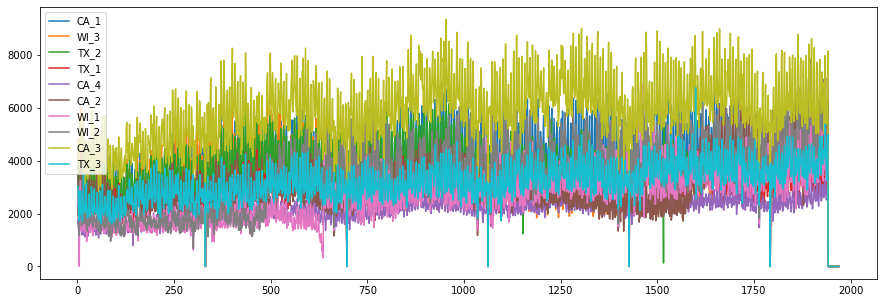

In [150]:
###　店舗ごとのトレンドを確認

stores = df_store_sum["store_id"].unique()
f,ax = plt.subplots(figsize=(15,5))
for i,store in enumerate(stores):
    filter = (df_mean["store_id"]==store)
    x = df_store_sum[filter]["d"]
    y = df_store_sum[filter]["sold"]
    ax.plot(x,y,label=store)
ax.legend()
f.show()

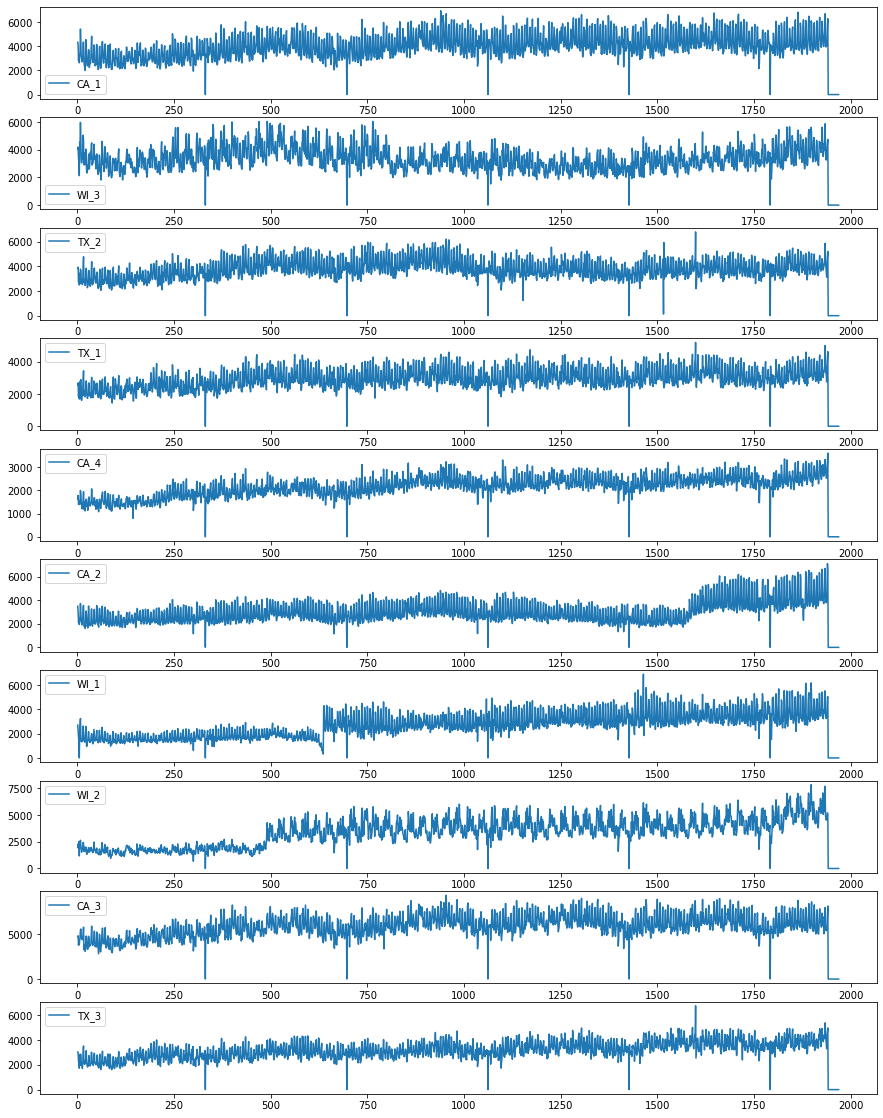

In [151]:
### 店舗ごとのトレンドを確認

stores = df_store_sum["store_id"].unique()
f,axes = plt.subplots(len(stores),figsize=(15,20))
for i,store in enumerate(stores):
    filter = (df_mean["store_id"]==store)
    x = df_store_sum[filter]["d"]
    y = df_store_sum[filter]["sold"]
    axes[i].plot(x,y,label=store)
    axes[i].legend()
f.show()

In [152]:
### 店舗ごとに商品ごとにトレンドを確認

df_store_cat_sum = df.groupby(["store_id","dept_id","d"]).sum().sort_values(by="d").reset_index()

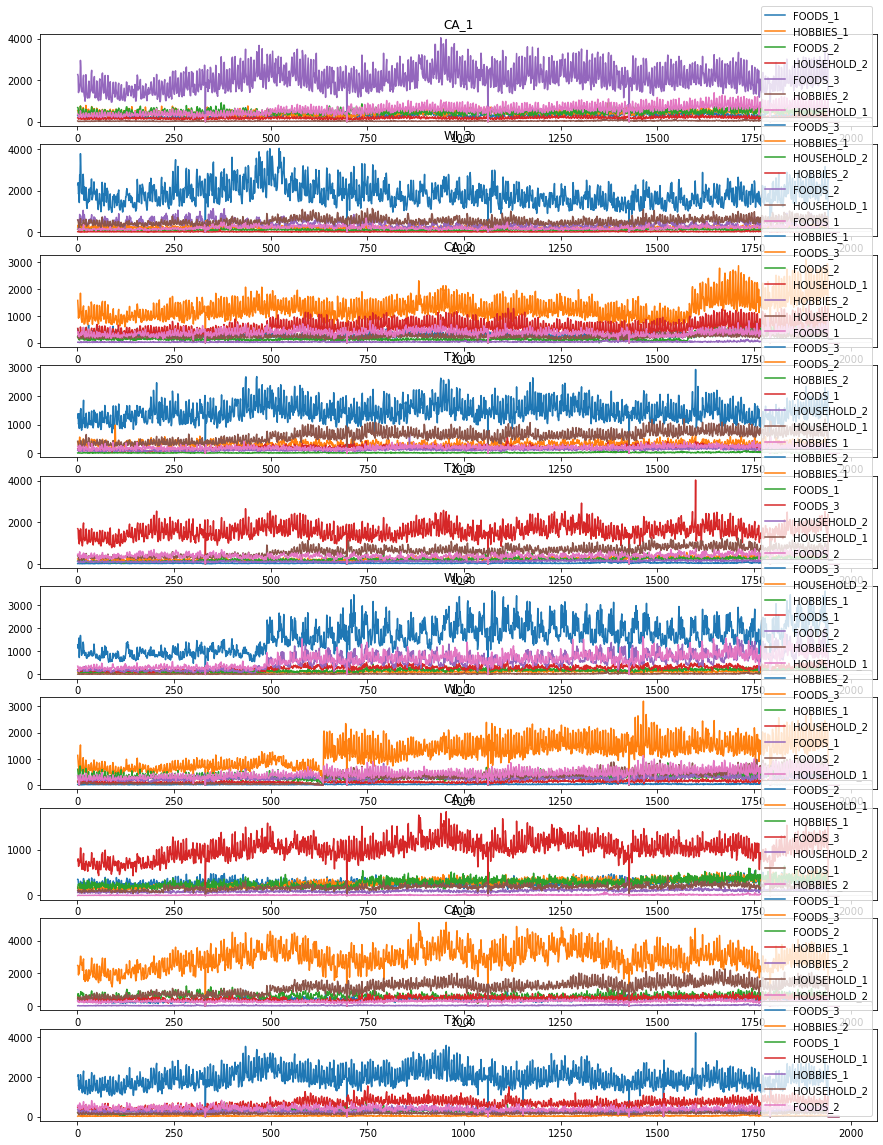

In [159]:

stores = df_store_cat_sum["store_id"].unique()
f,axes = plt.subplots(len(stores),figsize=(15,20))
for i, store in enumerate(stores):
    filter1 = (df_store_cat_sum["store_id"]==store)
    categories = df_store_cat_sum[filter1]["dept_id"].unique()
    for cat in categories:
        filter2 = (df_store_cat_sum[filter1]["dept_id"]==cat)
        x = df_store_cat_sum[filter1&filter2]["d"]
        y = df_store_cat_sum[filter1&filter2]["sold"]
        axes[i].plot(x,y,label=cat)
        axes[i].legend()
    axes[i].set_title(store)

f.show()